In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from scipy import stats
from func.myfunc import *

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn import metrics
from sklearn import feature_selection

import category_encoders as ce

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from geopy import Nominatim

import pickle
import joblib
import optuna


## Обработка выбросов, кодирование признаков

In [ ]:
# Загружаем и проверяем данные
df = pd.read_csv('./data/auto_data.csv')
display(df.head())


,availability,generation,year,mileage,body,color,tax,transmission,drive,steering_wheel,...,pedal_pads,door_sills,seat_count,active_suspension,sport_suspension,air_suspension,full_spare_wheel,spare_wheel,towbar,crankcase_prot
0,В наличии,Не указано,2024,15,минивэн,белый,5559,автоматическая,передний,Левый,...,Не указано,Не указано,7,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано
1,В наличии,II,2019,84936,седан,серебристый,1156,механическая,передний,Левый,...,Не указано,Не указано,5,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано
2,В наличии,Не указано,2022,54389,пикап двойная кабина,зелёный,8150,автоматическая,полный,Левый,...,Не указано,Не указано,4,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано
3,В наличии,II (981),2013,16785,купе,белый,32240,роботизированная,задний,Левый,...,Не указано,Накладки на пороги,2,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано
4,В наличии,I Рестайлинг,2012,270000,седан,чёрный,7600,роботизированная,передний,Левый,...,Не указано,Накладки на пороги,4,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано,Не указано


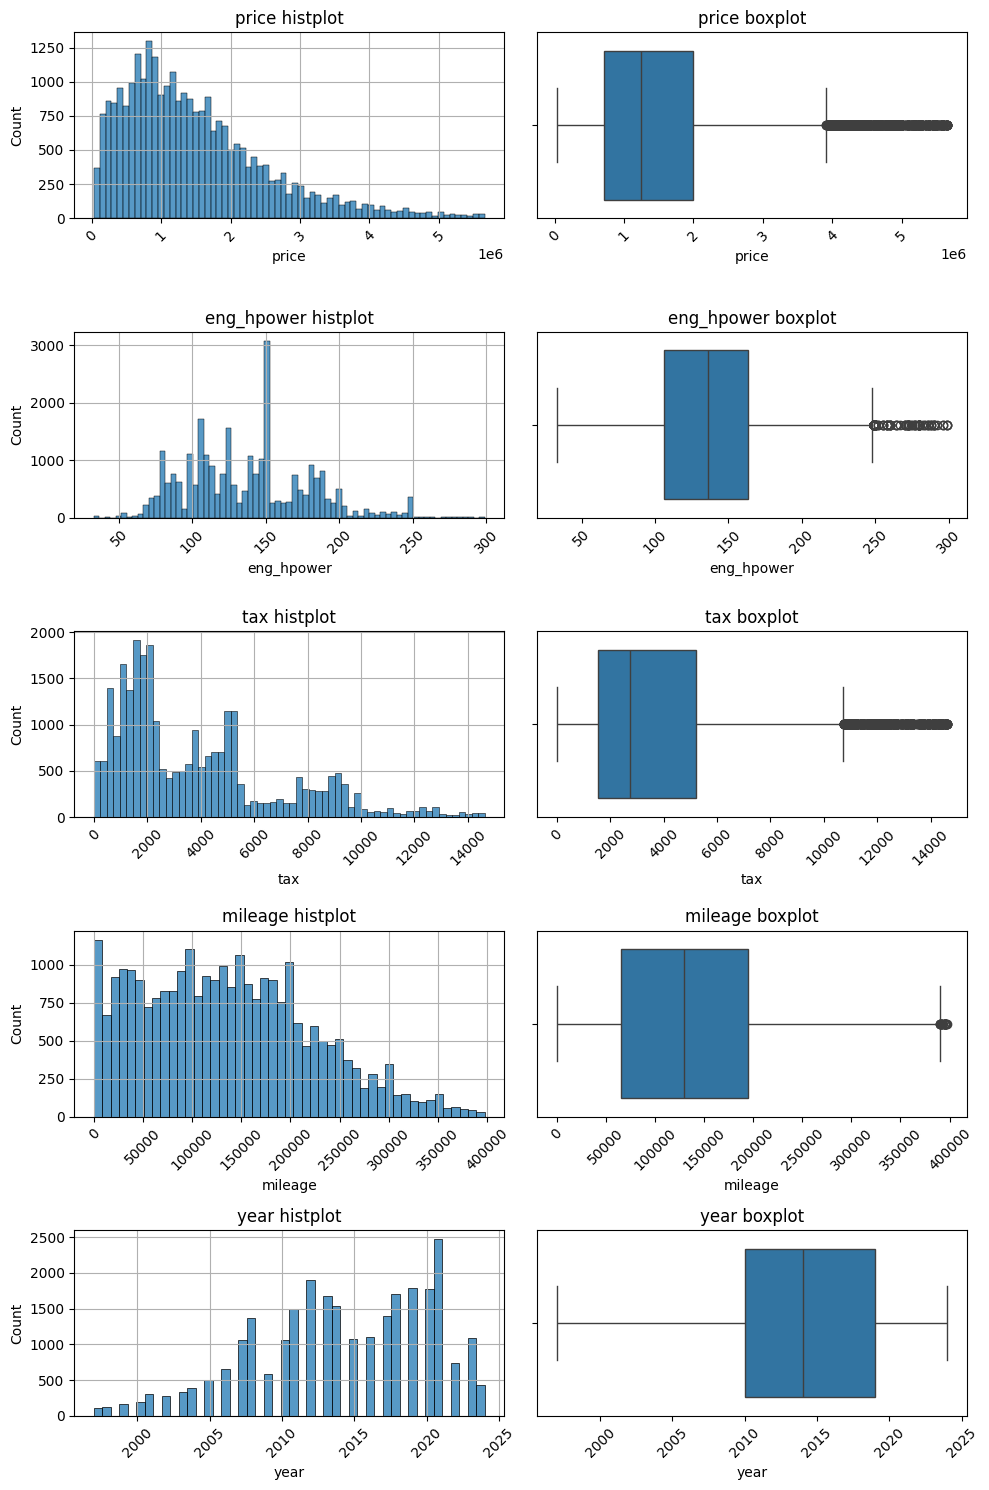

In [ ]:
# Обработаем выбросы в данных с помощью метода межквартильных инетрвалов.
# Задаем список признаков для обработки выбросов определенных на этапе
# разведывательного анализа данных.
features = ['price', 'eng_hpower', 'tax', 'mileage', 'year']

# В цикле перебираем список признаков features
for feature in features:

    # Используем функцию outliers_irq из модуля myfunc и переопределяем наш
    # датасет
    _, df = outliers_irq(df, feature)

# Проверим результат. Задаем фигуру n х 2 координатных плоскостей
fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(10, 15))

# Создаем цикл для всех признаков из списка features
# i- индекс, feature - название признака в таблице
for i, feature in enumerate(features):

    # Строим гистограмму распределения признака
    histplot = sns.histplot(data=df, x=feature, ax=axes[i][0])

    # Добавляем подпись графику
    histplot.set_title('{} histplot'.format(feature))

    # Добавляем сетку
    histplot.grid()

    # Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)

    # Строим диаграмму размаха
    boxplot = sns.boxplot(data=df, x=feature, ax=axes[i][1])

    # Добавляем подпись графику
    boxplot.set_title('{} boxplot'.format(feature))

    # Добавляем поворот отметок на оси абсцисс
    boxplot.xaxis.set_tick_params(rotation=45)

# выравнивание графиков
plt.tight_layout()


Мы практически избавились от выбросов в признаках год выпуска и пробег. В признаках цена, налог и мощность двигателя остались аномальные значения справа, но их уже значительно меньше. Остановимся на этом.

In [ ]:
# Займемся кодированием признаков. Создаем список наименований признаков
# с большим количеством уникальных значений
for_binary_ls = ['availability',
                 'transmission',
                 'drive',
                 'condition',
                 'owners',
                 'pts',
                 'eng_type',
                 'body',
                 'color',
                 'sity'
                 ]

# Создадим список для хранения наименований категориальных признаков
# с малым количеством уникальных значений
low_uniq_cat = []

# В цикле перебираем категориальные признаки
for feature in list(df.dtypes[(df.dtypes == 'object')].index):

    # Проверяем число уникальных значений и заносим признак в
    # соответствующий список
    if df[feature].nunique() <= 10:
        low_uniq_cat.append(feature)

# А также список для однократного кодирования исключив из списка
# low_uniq_cat признаки с количеством уникальных значений более двух
for_dummy_ls = [i for i in low_uniq_cat if i not in for_binary_ls]

# Оставим в списке только те признаки которые содержат значение 'Не указано'
for_dummy_ls = [i for i in for_dummy_ls if i not in ['steering_wheel',
                                                     'customs'
                                                     ]
                ]

# Сериализуем и запишем список for_dummy_ls в файл
with open('./file_pkl/for_dummy_ls.pkl', 'wb') as file:
    pickle.dump(for_dummy_ls, file)

# Закодируем признаки из списка для однократного кодирования применив лямбда
# функцию
for i in for_dummy_ls:
    df[i] = df[i].map(lambda x: 0 if x == 'Не указано' else 1)

# Создадим вспомогательный датасет, закодировав и разделив оставшиеся два
# признака ('steering_wheel', 'customs') на четыре, аналогичной лямбда
# функцией
df1 = pd.DataFrame(df['steering_wheel'].map(
      lambda x: 1 if x == 'Левый' else 0))
df1['steering_wheel_r'] = df['steering_wheel'].map(
      lambda x: 1 if x == 'Правый' else 0)
df1['customs_pts'] = df['customs'].map(
      lambda x: 1 if x == 'Растаможен' else 0)
df1['customs_no_pts'] = df['customs'].map(
      lambda x: 1 if x == 'Растаможен, нет ПТС' else 0)

# Переименуем первый признак
df1.rename(columns={'steering_wheel': 'steering_wheel_l'}, inplace=True)

# Удалим из исходного датасета изначальные (мы их уже закодировали) признаки
df.drop(['steering_wheel', 'customs'], inplace=True, axis=1)

# Добавим закодированные признаки к исходному датасету, исключив из него
# признак 'sity' (он уже приведен в виде долготы и широты) и проверим размер
# данных
df = pd.concat([df.drop('sity', axis=1), df1], axis=1)

# Сбрасываем значения индексов и проверяем результат
df = df.reset_index(drop=True)
display(df.head())


,availability,generation,year,mileage,body,color,tax,transmission,drive,condition,...,sport_suspension,air_suspension,full_spare_wheel,spare_wheel,towbar,crankcase_prot,steering_wheel_l,steering_wheel_r,customs_pts,customs_no_pts
0,В наличии,Не указано,2024,15,минивэн,белый,5559,автоматическая,передний,Не требует ремонта,...,0,0,0,0,0,0,1,0,1,0
1,В наличии,II,2019,84936,седан,серебристый,1156,механическая,передний,Не требует ремонта,...,0,0,0,0,0,0,1,0,1,0
2,В наличии,Не указано,2022,54389,пикап двойная кабина,зелёный,8150,автоматическая,полный,Не требует ремонта,...,0,0,0,0,0,0,1,0,1,0
3,В наличии,I Рестайлинг,2012,270000,седан,чёрный,7600,роботизированная,передний,Не требует ремонта,...,0,0,0,0,0,0,1,0,1,0
4,В наличии,II Рестайлинг,2020,110000,седан,белый,205,механическая,передний,Не требует ремонта,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
# Задаем значение для воспроизводимости результатов
seed = 42

# Создаем матрицу признаков
x = df.drop('price', axis=1)

# Формируем вектор правильных ответов.
y = df['price']

# Делим данные на тренировочную (4/5) и тестовую (1/5) выборки
x_train, x_test, y_train, y_test = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=seed, shuffle=True)

# Проверяем результат
print('x train: ', x_train.shape)
print('x test: ', x_test.shape)
print('y train: ', y_train.shape)
print('y test: ', y_test.shape)


x train:  (21900, 197)
x test:  (5476, 197)
y train:  (21900,)
y test:  (5476,)


In [ ]:
# Создаем список признаков для бинарного кодирования
for_binary_ls = ['availability',
                 'transmission',
                 'drive',
                 'condition',
                 'owners',
                 'pts',
                 'eng_type',
                 'body',
                 'color',
                 'brand',
                 'model',
                 'generation'
                 ]

# Создаем объект класса BinaryEncoder
bin_encoder = ce.BinaryEncoder(cols=for_binary_ls)

# Подбираем параметры кодировщика на тренировочной выборке
bin_encoder.fit(x_train[for_binary_ls])

# Кодируем признаки для тренировочной выборки
data = bin_encoder.transform(x_train[for_binary_ls])

# Удаляем из тренировочной выборки исходные признаки и добавляем результат
# кодирования
x_train = pd.concat([x_train.drop(for_binary_ls, axis=1), data], axis=1)

# Повторяем кодированияе для тестовой выборки
data = bin_encoder.transform(x_test[for_binary_ls])
x_test = pd.concat([x_test.drop(for_binary_ls, axis=1), data], axis=1)

# Сериализуем и запишем bin_encoder в файл
with open('./file_pkl/bin_encoder.pkl', 'wb') as file:
    pickle.dump(bin_encoder, file)


## Построение базовой модели

In [ ]:
# В качестве базовой модели используем линейную регрессию
model = LinearRegression()

# Обучаем модель
model.fit(x_train, y_train)

# Делаем предсказание для тренировочной и тестовой выборки
tr_pred = model.predict(x_train)
ts_pred = model.predict(x_test)

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 35.162118834316416
TS MAPE 34.641293638440764
TR R^2 82.91380345525631
TS R^2 81.88843620376015
--------------------------------------------------


В качестве метрик используем коэффициент детерминации и среднюю абсолютную ошибку в процентах. Коэффициент детерминации значительно больше 0.5 - модель определенно работает лучше, чем просто замена всех предсказаний  на среднее значение правильных ответов. Судя по метрике МАРЕ модель в среднем ошибается на 35% - это довольно много. Разница между значениями метрик на тестовой и тренировочной выборках невелика, значит переобучения модели не наблюдается.

In [ ]:
# Проверим влияние признаков с сильной корреляцией на результаты работы
# модели. Создаем матрицу корреляции
corr = x_train.corr()

# Оставляем только верхний треугольник матрицы корреляции
df_corr = pd.DataFrame(np.triu(corr),
                       columns=corr.columns,
                       index=corr.columns
                       )

# Создаем список с различными порогами силы корреляции
bound_ls = [0.75, 0.85, 0.95]

# Проходим в цикле по каждому значению порога силы корреляции
for bound_corr in bound_ls:

    # Формируем маску для значений матрицы корреляции выходящие за текущее
    # значение порога
    mask = df_corr.apply(lambda x: (((x > bound_corr) & (x != 0)) |
                                    ((x < -bound_corr) & (x != 0))), axis=1)

    # Задаем список для сбора наименований признаков с сильной корреляцией
    ls_p = list()

    # Во вложенном цикле перебираем значения маски
    for i in mask.index:
        for j in mask.columns:

            # если значение в ячейке истинно, а индек столбца и строки
            # не совпадают (т.е. это не корреляция признака с самим собой)
            # записываем имена признаков и силу их корреляции в список
            if (mask.loc[i][j]) and (i != j):
                ls_p.append([i, j, str(round(df_corr.loc[i][j], 2))])

    # Выберем первый из пары признаков с высокой корреляцией
    feature_corr = list(set([name[0] for name in ls_p]))

    # Удаляем признаки с высокой корреляцией
    x_tr = x_train.drop(feature_corr, axis=1)
    x_ts = x_test.drop(feature_corr, axis=1)

    # Создаем модель
    model = LinearRegression()

    # Обучаем модель
    model.fit(x_tr, y_train)

    # Делаем предсказание для тренировочной и тестовой выборки
    tr_pred = model.predict(x_tr)
    ts_pred = model.predict(x_ts)

    # Рассчитываем и выводим метрики
    print(f'Удалены признаки с силой корреляции более {bound_corr}')
    print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                            y_pred=tr_pred
                                                            )*100)
    print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                            y_pred=ts_pred
                                                            )*100)
    print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
    print('-'*50)


Удалены признаки с силой корреляции более 0.75
TR MAPE 35.24336530020057
TS MAPE 34.583592755731914
TR R^2 82.5314679954733
TS R^2 81.66525347474067
--------------------------------------------------
Удалены признаки с силой корреляции более 0.85
TR MAPE 34.95762708624144
TS MAPE 34.45924772914079
TR R^2 82.79284726468572
TS R^2 81.7603723329631
--------------------------------------------------
Удалены признаки с силой корреляции более 0.95
TR MAPE 35.14386182690778
TS MAPE 34.607071812007284
TR R^2 82.88732247848324
TS R^2 81.86344607913048
--------------------------------------------------


Удаление признаков с сильной корреляционной связью незначительно улучшило метрику МАРЕ. Однако это привело к падению метрики R квадрат. Наилучший прирос метрики МАРЕ наблюдается для порога 0.85 и состовляет на тренировочных данных порядка 0.2, на тестовых - 0.18. При этом падение метрики R квадрат для тренировочных и тестовых данных около 0,12. Выберем порог силы корреляции равный 0.85, все признаки с большей корреляцией исключим.

In [ ]:
# Формируем маску для значений матрицы корреляции выходящие за значение
# порога 0,85
mask = df_corr.apply(lambda x: (((x > 0.85) & (x != 0)) |
                                ((x < -0.85) & (x != 0))), axis=1)

# Задаем список для сбора наименований признаков с сильной корреляцией
ls_p = list()

# Во вложенном цикле перебираем значения маски
for i in mask.index:
    for j in mask.columns:

        # если значение в ячейке истинно, а индек столбца и строки
        # не совпадают (т.е. это не корреляция признака с самим собой)
        # записываем имена признаков и силу их корреляции в список
        if (mask.loc[i][j]) and (i != j):
            ls_p.append([i, j, str(round(df_corr.loc[i][j], 2))])

# Выберем первый из пары признаков с высокой корреляцией
feature_corr = list(set([name[0] for name in ls_p]))

# Сериализуем и запишем список признаков в файл
with open('./file_pkl/feature_corr.pkl', 'wb') as file:
    pickle.dump(feature_corr, file)

# Удаляем признаки с высокой корреляцией из наборов данных
x_train = x_train.drop(feature_corr, axis=1)
x_test = x_test.drop(feature_corr, axis=1)


In [ ]:
# Как было видно на этапе разведываетльного анализа практически все признаки
# не имеют нормального распределения. Попробуем различные варианты сочетаний
# стандартизации и нормализации данных для численного решения линейной
# регресии. Задаем пайплайны
pipeline_s = Pipeline([('s_scaler', StandardScaler()),
                       ('model_lr',
                        linear_model.SGDRegressor(random_state=seed)
                        )
                       ]
                      )

pipeline_mm = Pipeline([('mm_scaler', MinMaxScaler()),
                        ('model_lr',
                         linear_model.SGDRegressor(random_state=seed)
                         )
                        ]
                       )

pipeline_r = Pipeline([('r_scaler', RobustScaler()),
                       ('model_lr',
                        linear_model.SGDRegressor(random_state=seed)
                        )
                       ]
                      )

pipeline_s_mm = Pipeline([('s_scaler', StandardScaler()),
                          ('mm_scaler', MinMaxScaler()),
                          ('model_lr',
                           linear_model.SGDRegressor(random_state=seed)
                           )
                          ]
                         )

pipeline_s_r = Pipeline([('s_scaler', StandardScaler()),
                         ('r_scaler', RobustScaler()),
                         ('model_lr',
                          linear_model.SGDRegressor(random_state=seed)
                          )
                         ]
                        )

pipeline_mm_s = Pipeline([('mm_scaler', MinMaxScaler()),
                          ('s_scaler', StandardScaler()),
                          ('model_lr',
                           linear_model.SGDRegressor(random_state=seed)
                           )
                          ]
                         )

pipeline_r_s = Pipeline([('r_scaler', RobustScaler()),
                         ('s_scaler', StandardScaler()),
                         ('model_lr',
                          linear_model.SGDRegressor(random_state=seed)
                          )
                         ]
                        )

# Создаем список из пайплайнов и список имен для отображения в выводе
pipe_ls = [pipeline_s,
           pipeline_mm,
           pipeline_r,
           pipeline_s_mm,
           pipeline_s_r,
           pipeline_mm_s,
           pipeline_r_s
           ]
pipe_name = ['pipeline_s',
             'pipeline_mm',
             'pipeline_r',
             'pipeline_s_mm',
             'pipeline_s_r',
             'pipeline_mm_s',
             'pipeline_r_s'
             ]

# Задаем списки для сбора значений метрик
tr_mape = []
ts_mape = []
tr_r2 = []
ts_r2 = []

# В цикле проводим обучение пайплайнов
for num, pipe in enumerate(pipe_ls):
    pipe.fit(x_train, y_train)

    # Делаем предсказание для тренировочной и тестовой выборки
    tr_pred = pipe.predict(x_train)
    ts_pred = pipe.predict(x_test)

    # Рассчитываем метрики и заносим их в список
    tr_mape.append(metrics.mean_absolute_percentage_error(y_true=y_train,
                                                          y_pred=tr_pred
                                                          )*100)
    ts_mape.append(metrics.mean_absolute_percentage_error(y_true=y_test,
                                                          y_pred=ts_pred
                                                          )*100)
    tr_r2.append(metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    ts_r2.append(metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)

# Формируем  датафрейм из полученных списокв
metric = pd.DataFrame({'name': pipe_name,
                       'tr_mape': tr_mape,
                       'ts_mape': ts_mape,
                       'tr_r2': tr_r2,
                       'ts_r2': ts_r2
                       }
                      )

# Выводим результат
display(metric)


,name,tr_mape,ts_mape,tr_r2,ts_r2
0,pipeline_s,236065.925206,191522.077462,-1.017111e+11,-8.645487e+08
1,pipeline_mm,34.884872,34.382112,8.262739e+01,8.173040e+01
2,pipeline_r,34.749771,34.241023,8.274200e+01,8.179090e+01
3,pipeline_s_mm,34.884872,34.382112,8.262739e+01,8.173040e+01
4,pipeline_s_r,427929.308213,384405.923887,-6.525622e+10,-1.687228e+10
5,pipeline_mm_s,236065.925206,191522.077462,-1.017111e+11,-8.645487e+08
6,pipeline_r_s,236065.925206,191522.077462,-1.017111e+11,-8.645487e+08


Лучший результат показал пайплайн с робастной нормализацией. Уменьшении метрики МАРЕ по сравнению с аналитическим решением линейной регресии составило 0.208 и 0.218 для тренировочной и тестовой выборок. Метрика R квадрат для тренировочной выборки снизилась на 0.05, а для тестовой выборки выросла на 0.03.

In [ ]:
# Целевой показатель также имеет большой разброс - попробуем применить
# логарифмирование целевого признака. Обучаем скейлер с логарифмированием
# целевого признака
r_scaler = RobustScaler()
r_scaler.fit(X=x_train, y=np.log(y_train+1))

# Сериализуем и запишем r_scaler в файл
with open('./file_pkl/r_scaler.pkl', 'wb') as file:
    pickle.dump(r_scaler, file)

x_tr_r = pd.DataFrame(r_scaler.transform(X=x_train), columns=x_train.columns)
x_ts_r = pd.DataFrame(r_scaler.transform(X=x_test), columns=x_test.columns)

# Сериализуем и запишем список с порядком столбцов в файл
with open('./file_pkl/col_order.pkl', 'wb') as file:
    pickle.dump(list(x_ts_r.columns), file)

sgd = linear_model.SGDRegressor(random_state=seed)
sgd.fit(x_tr_r, np.log(y_train+1))

tr_pred = np.exp(sgd.predict(x_tr_r))-1
ts_pred = np.exp(sgd.predict(x_ts_r))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 24.894013664000262
TS MAPE 25.180117887447008
TR R^2 78.0191023552876
TS R^2 76.76389891758394
--------------------------------------------------


Использование логарифмирования целевого признака позволило значительно улучшить метрику МАРЕ на 9.85 и 9.06 для тренировочной и тестововй выборок соответственно. Метрика R квадрат снизилась на 4.73 и 5.03 соответственно.

## ОТБОР ПРИЗНАКОВ

In [ ]:
# Проведем отбор признаков
# Используем метод рекурсивного исключения признаков
selector_rfe = RFE(estimator=LinearRegression(),
                   n_features_to_select=50,
                   step=1000
                   )

# Обучаем селектор
selector_rfe = selector_rfe.fit(x_tr_r, np.log(y_train+1))

# Сохраняем список 50 важных признаков в переменную
best_rfe = selector_rfe.get_feature_names_out()

# Используем метод отбора признаков на основе фильтров (статистических тестов)
# Выделим в список наименования числовых признаков
num_features = ['year',
                'mileage',
                'eng_hpower',
                'lat',
                'long',
                'cnt_exterior',
                'cnt_comfort',
                'cnt_other',
                'd_size',
                'seat_count'
                ]

# Теперь создаем список категориальных признаков
cat_features = [i for i in x_tr_r if i not in num_features]

# Для выбора 10 наиболее значимых признаков из числовых в
# качестве фильтра используем коэффициент корреляции Пирсона
num_selector = SelectKBest(f_regression, k=5)

# Обучаем селектор и записываем наименования признаков в переменную
num_selector.fit(x_tr_r[num_features], np.log(y_train+1))
kbest_num = num_selector.get_feature_names_out()

# Для отбора 40 категориальных признаков в качестве фильтра испоьзуем
# тест ANOVA
cat_selector = SelectKBest(f_classif, k=45)

# Обучаем селектор и записываем наименования признаков в переменную
cat_selector.fit(x_tr_r[cat_features], np.log(y_train+1))
kbest_cat = cat_selector.get_feature_names_out()

# Объединяем наименования признаков в один список
k_best = list(kbest_num) + list(kbest_cat)


In [ ]:
# Воспользуемся моделью дерева решений для отбора наиболее важных признаков
# Создаем модель
model_dt = DecisionTreeRegressor(max_depth=9,
                                 min_samples_leaf=5,
                                 random_state=seed
                                 )
# Обучаем модель
model_dt.fit(x_tr_r, np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model_dt.predict(x_tr_r))-1
ts_pred = np.exp(model_dt.predict(x_ts_r))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 19.545573344182774
TS MAPE 21.81766229834153
TR R^2 85.7076158828425
TS R^2 81.97020158710721
--------------------------------------------------


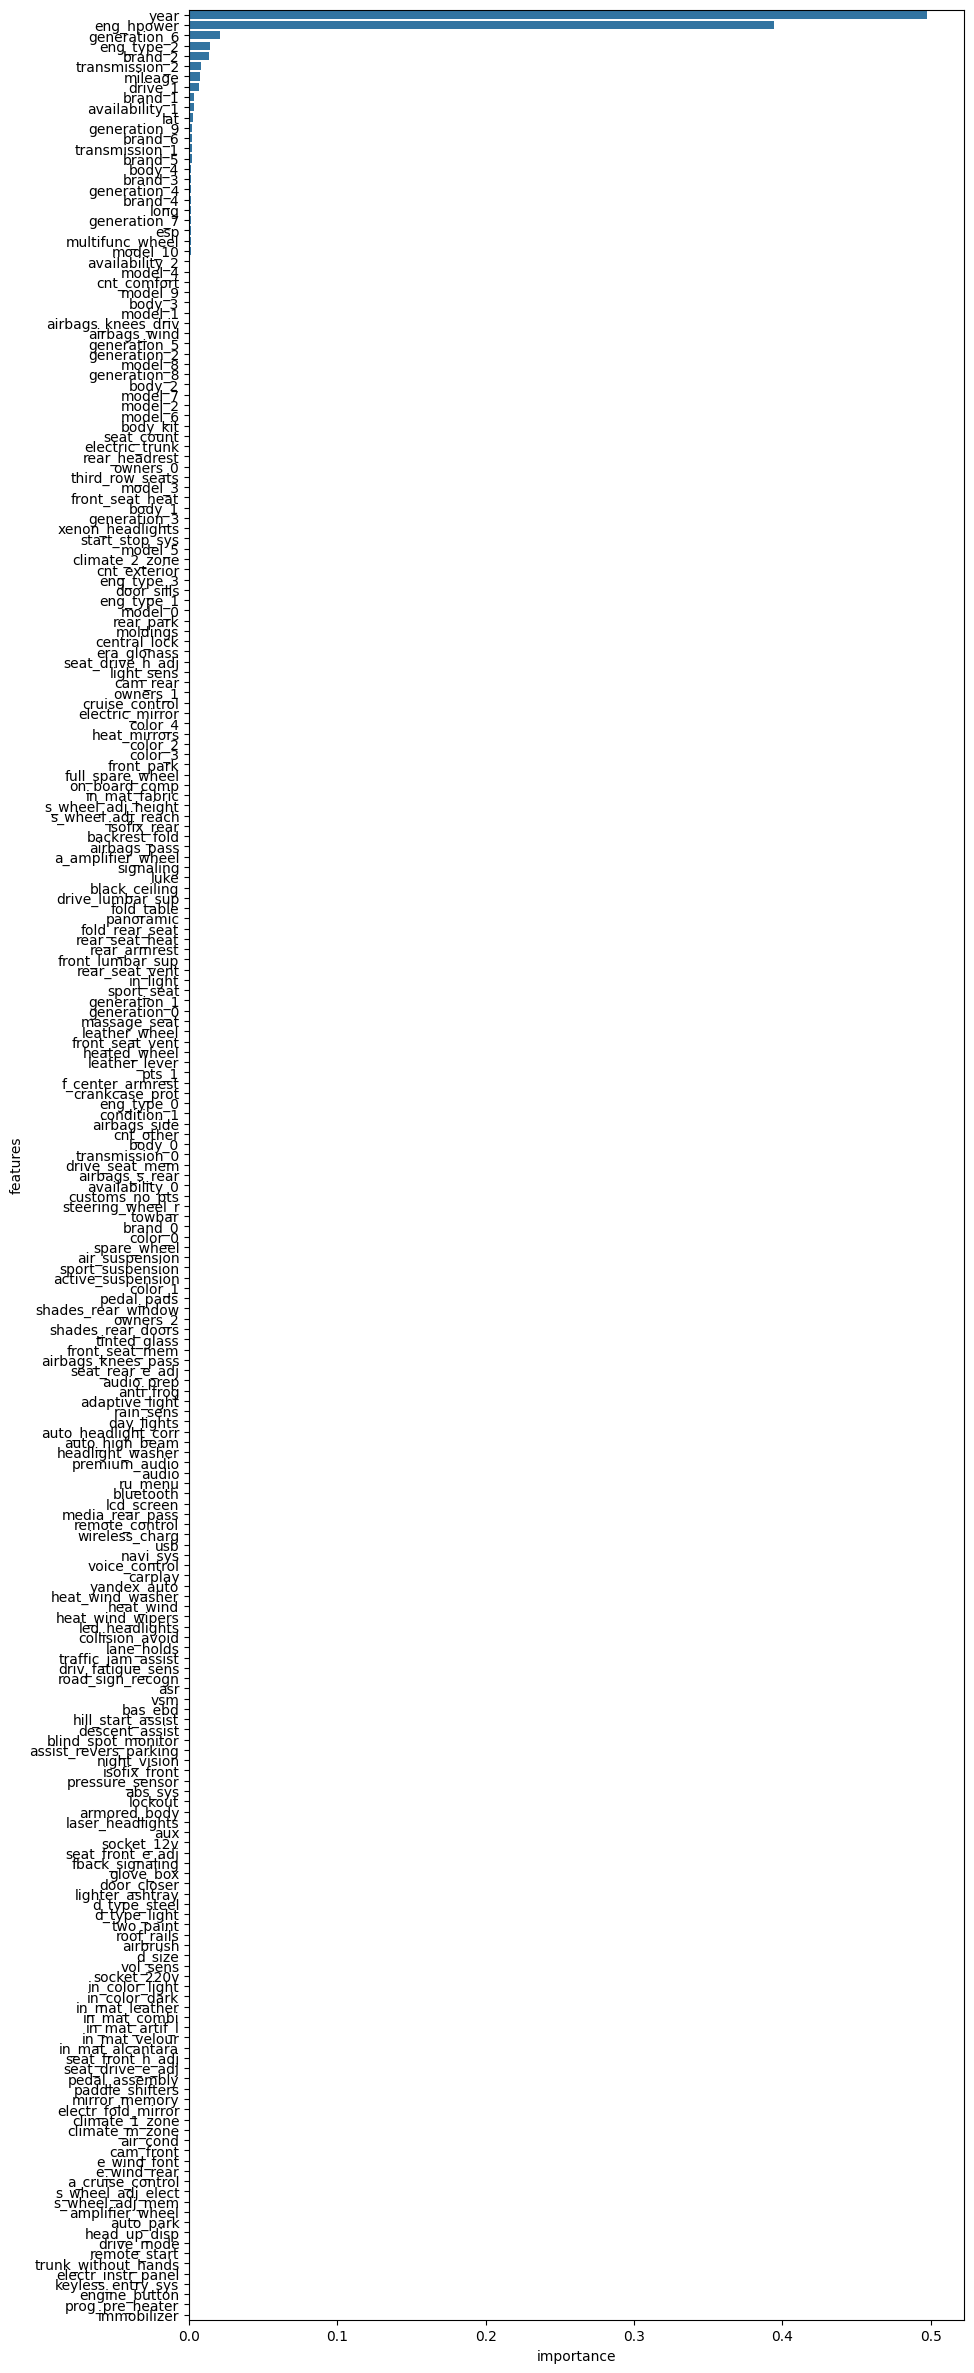

In [ ]:
# Формируем датафрейм с важностью признаков
dt_data = pd.DataFrame({'features': model_dt.feature_names_in_,
                        'importance': model_dt.feature_importances_
                        }
                       )

# Визуализируем важность признаков
fig, ax = plt.subplots(figsize=(10, 30))
sns.barplot(y=dt_data.sort_values(by='importance',
                                  ascending=False
                                  )['features'],
            x=dt_data.sort_values(by='importance',
                                  ascending=False
                                  )['importance'],
            ax=ax
            )

# На диаграмме видно, что важность признаков быстро падает.
# Отберем 50 наиболее значимых признаков
dt_importance = list(dt_data.sort_values(by='importance',
                                         ascending=False
                                         ).head(50)['features'].values)


In [ ]:
# В качестве альтернативы отбору признаков можно попробовать методы
# снижения размерности. Используем метод главных компонент (PCA) для
# приведения наших исходных данных к 50 компонентам
pca = PCA(n_components=50, random_state=seed)

# Обучаем алгоритм
pca.fit(x_tr_r)

# Трансформируем наши выборки
pca_tr = pca.transform(x_tr_r)
pca_ts = pca.transform(x_ts_r)

# Используем метод сингулярного разложения (SVD) для приведения наших
# данных к 50 компонентам
svd = TruncatedSVD(n_components=50, random_state=seed, n_iter=500)

# Обучаем алгоритм
svd.fit(x_tr_r)

# Трансформируем наши выборки
svd_tr = svd.transform(x_tr_r)
svd_ts = svd.transform(x_ts_r)


In [ ]:
# Проверим метрики модели на данных с различными способами отбора признаков.
# Создадим списки с данными для тренировочной и тестовой выборки, а также
# список с наименованиями способов отбора
train_ls = [x_tr_r,
            x_tr_r[best_rfe],
            x_tr_r[k_best],
            x_tr_r[dt_importance],
            pca_tr,
            svd_tr
            ]
test_ls = [x_ts_r,
           x_ts_r[best_rfe],
           x_ts_r[k_best],
           x_ts_r[dt_importance],
           pca_ts,
           svd_ts
           ]
name_ls = ['full data', 'rfe', 'k_best', 'dt_importance', 'pca', 'svd']

# Задаем списки для сбора значений метрик
tr_mape = []
ts_mape = []
tr_r2 = []
ts_r2 = []
name = []
# В цикле проводим обучение модели на данных с различными способами отбора
# признаков
for num in range(len(name_ls)):
    sgd = linear_model.SGDRegressor(random_state=seed)
    sgd.fit(train_ls[num], np.log(y_train+1))

    # Делаем предсказания для тестовой и тренировочной выборки
    tr_pred = np.exp(sgd.predict(train_ls[num]))-1
    ts_pred = np.exp(sgd.predict(test_ls[num]))-1

    # Рассчитываем метрики и заносим их в списки
    name.append(name_ls[num])
    tr_mape.append(metrics.mean_absolute_percentage_error(y_true=y_train,
                                                          y_pred=tr_pred
                                                          )*100)
    ts_mape.append(metrics.mean_absolute_percentage_error(y_true=y_test,
                                                          y_pred=ts_pred
                                                          )*100)
    tr_r2.append(metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    ts_r2.append(metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)

# Формируем  датафрейм из полученных списокв
metric = pd.DataFrame({'name': name,
                       'tr_mape': tr_mape,
                       'ts_mape': ts_mape,
                       'tr_r2': tr_r2,
                       'ts_r2': ts_r2
                       }
                      )

# Выводим результат
display(metric)


,name,tr_mape,ts_mape,tr_r2,ts_r2
0,full data,24.894014,25.180118,78.019102,76.763899
1,rfe,24.053361,24.251901,79.859599,77.885389
2,k_best,28.088752,28.227221,76.429002,73.970222
3,dt_importance,23.860326,24.007286,79.876458,78.496473
4,pca,26.931130,27.139171,75.662894,74.364571
5,svd,27.411189,27.570568,74.619528,73.505498


Лучший результат был получен при обучении модели на признаках отобранных с помощью дерева решений. В среднем ошибка модели сократилась на 1.03 и 1.18 процента для тренировочной и тестовой выборок соответственно. Метрика R квадрат выросла на 1.86 и 1.73 для тренировочной и тестовой выборок соответственно.

,tr_mape,ts_mape,tr_r2,ts_r2
128,23.462365,23.602757,80.569596,79.26937


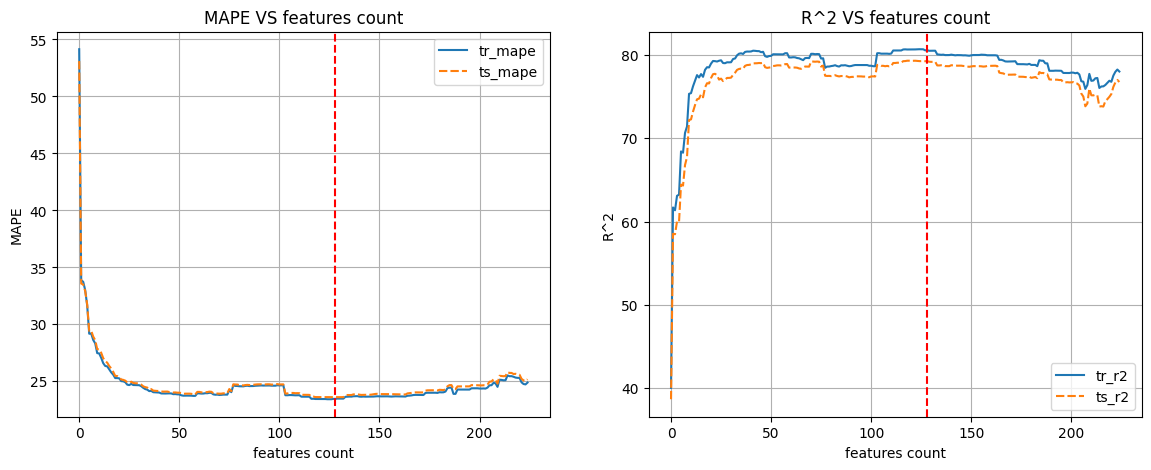

In [ ]:
# Найдем оптимальное количество признаков с точки зрения уменьшения метрики
# МАРЕ на тестововй выборке. Определим списки для сбора значений метрик
tr_mape = []
ts_mape = []
tr_r2 = []
ts_r2 = []

# В цикле проводим обучение модели на данных с различным числом признаков
# отборанных с помощью дерева решений
for num in range(1, len(x_tr_r.columns)+1):
    dt_importance = list(dt_data.sort_values(by='importance',
                                             ascending=False
                                             ).head(num)['features'].values
                         )

    # Определяем и обучаем модель
    sgd = linear_model.SGDRegressor(random_state=seed)
    sgd.fit(x_tr_r[dt_importance], np.log(y_train+1))

    # Делаем предсказания для тестовой и тренировочной выборки
    tr_pred = np.exp(sgd.predict(x_tr_r[dt_importance]))-1
    ts_pred = np.exp(sgd.predict(x_ts_r[dt_importance]))-1

    # Рассчитываем метрики и заносим их в списки
    tr_mape.append(metrics.mean_absolute_percentage_error(y_true=y_train,
                                                          y_pred=tr_pred
                                                          )*100)
    ts_mape.append(metrics.mean_absolute_percentage_error(y_true=y_test,
                                                          y_pred=ts_pred
                                                          )*100)
    tr_r2.append(metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    ts_r2.append(metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)

# Формируем  датафрейм из полученных списокв
metric = pd.DataFrame({'tr_mape': tr_mape,
                       'ts_mape': ts_mape,
                       'tr_r2': tr_r2,
                       'ts_r2': ts_r2
                       }
                      )

# Выводим лучший результат по метрике МАРЕ на тестовой выборке
display(metric[metric['ts_mape'] == metric['ts_mape'].min()])

# Строим графики. Определяем размер фигуры и количество полей
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

# На первом поле выводим графики для метрики МАРЕ
sns.lineplot(metric[['tr_mape', 'ts_mape']], ax=ax[0])

# На втором поле выводим графики для метрики R^2
sns.lineplot(metric[['tr_r2', 'ts_r2']], ax=ax[1])

# Строим вертикальную линию для отображения лучшего результатат по метрике МАРЕ
# для тестовой выборке на каждом поле
ax[0].axvline(x=metric[metric['ts_mape'] == metric['ts_mape'].min()].index[0],
              c='red',
              linestyle='--'
              )
ax[1].axvline(x=metric[metric['ts_mape'] == metric['ts_mape'].min()].index[0],
              c='red',
              linestyle='--'
              )

# Определяем имена осей, графиков и включаем отображение сетки
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('R^2')
ax[0].set_xlabel('features count')
ax[1].set_xlabel('features count')
ax[0].set_title('MAPE VS features count')
ax[1].set_title('R^2 VS features count')
ax[0].grid()
ax[1].grid()


Лучший результат по значению метрики МАРЕ на тестовой выборке был получен при обучении модели на 128 признаках отобранных с помощью дерева решений. В среднем ошибка модели сократилась на 0.4 процента для тренировочной и тестовой выборок. Метрика R квадрат выросла на 0.69 и 0.77 для тренировочной и тестовой выборок соответственно.

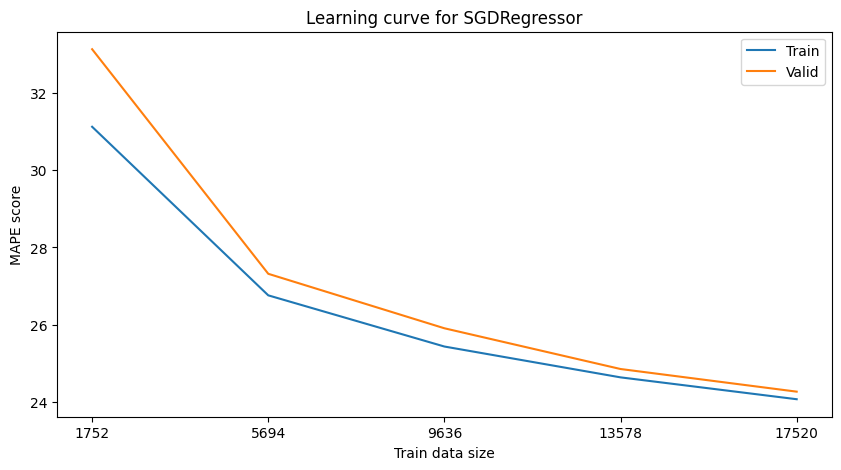

In [ ]:
# Задаем лучшее число признаков отобранных с помощью дерева решений
best_dt_importance = list(dt_data.sort_values(by='importance',
                                              ascending=False
                                              ).head(128)['features'].values
                          )

# Сериализуем и запишем список отобранных признаков в файл
with open('./file_pkl/best_dt_importance.pkl', 'wb') as file:
    pickle.dump(best_dt_importance, file)

# Построим кривую обучения для модели линейной регрессии,
# решаемой методом стохастического градиентного спуска
model = linear_model.SGDRegressor(random_state=seed)

# Задаем кросс-валидатор на 5 фолдов
skf = model_selection.StratifiedKFold(n_splits=5)

# Для построения графика используем функцию plot_learn_curve
# из модуля myfunc. Вектор правильных ответов передаем в
# логарифмированном виде.Для оценки метрики также используется
# функция из модуля myfunc. Она проводит преобразование векторов
# правильных ответов и предсказаний к нормальному масштабу перед
# вычислением метрики
plot_learn_curve(model=model,
                 cv=skf,
                 X=x_tr_r[best_dt_importance],
                 y=np.log(y_train+1),
                 scoring=get_score,
                 title='SGDRegressor'
                 )


Тренировочная и валидационная кривые находятся близко друг к другу и постоянно сближаются к единому значению метрики МАРЕ на уровне 24 процентов. Можно сделать вывод, что переобучения нет. Стоит попробовать подобрать гиперпараметры модели для улучшения метрики.

In [ ]:
# Попробуем улучшить качество подобрав гиперпараметры модели
# с помощью пакета OPTUNA.
# Определяем объект исследования.
# study_sgd = optuna.create_study(study_name='SGD',
#                                 direction='minimize')

# Так как это не первая итерация подбора параметров - загрузим
# созданный ранее объект исследования
study_sgd = joblib.load('./data/optuna_exp/experiments_sgd_r.pkl')


In [ ]:
# Задаем функцию для оптимизации
def opt_sgd(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Определяем пространство поиска
    loss = trial.suggest_categorical(name='loss',
                                     choices=['squared_error',
                                              'huber',
                                              'squared_epsilon_insensitive',
                                              'epsilon_insensitive',
                                              ]
                                     )
    penalty = trial.suggest_categorical(name='penalty',
                                        choices=['l2', 'l1', 'elasticnet']
                                        )
    alpha = trial.suggest_float(name='alpha',
                                low=0.0,
                                high=100,
                                step=0.0001
                                )

    # Создаем модель
    model = linear_model.SGDRegressor(penalty=penalty,
                                      alpha=alpha,
                                      loss=loss,
                                      max_iter=10000,
                                      random_state=seed
                                      )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    score = model_selection.cross_val_score(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score
                                            ).mean()

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл.
# Здесь и далее задано 0 итераций, чтобы не повторять поиск
for i in range(0):

    # Проводим подбор параметров и записываем обновленный объект
    # исследования в файл
    study_sgd.optimize(opt_sgd, n_trials=1)
    joblib.dump(study_sgd, './data/optuna_exp/experiments_sgd_r.pkl')

# Выводим настройки лучшей попытки и полученную при этом метрику
print('Best params SGD: ', study_sgd.best_params)
print('MAPE: ', study_sgd.best_value)


Best params SGD:  {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.008400000000000001}
MAPE:  23.66698053457023


In [ ]:
# Задаем модель с лучшими параметрами
model = linear_model.SGDRegressor(loss='squared_epsilon_insensitive',
                                  penalty='l2',
                                  alpha=0.0084,
                                  max_iter=10000,
                                  random_state=seed
                                  )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 22.866467679664837
TS MAPE 23.08444669857898
TR R^2 81.71441495081079
TS R^2 80.43429293372671
--------------------------------------------------


Подбор гиперпараметров модели позволил ещё на 0.5 процента улучшить метрику МАРЕ на тренировочной и тестововй выборках. Также получен прирост метрики R квадрат на величину порядка 1.3 для каждой выборки. Получена базовая модель, которая в среднем ошибается на 23 процента на тестововй выборке. Ошибка достаточно большая стоит попробовать более сложные модели.

## Decision Tree
Попробуем применить модель дерева решенийс подбором гиперпараметров в пакете OPTUNA

In [ ]:
#  Определяем объект исследования.
# study_dt = optuna.create_study(study_name='DT',
#                                 direction='minimize')

# Так как это не первая итерация подбора параметров - загрузим
# созданный ранее объект исследования
study_dt = joblib.load('./data/optuna_exp/experiments_dt.pkl')


In [ ]:
# Задаем функцию для оптимизации
def opt_dt(trial):
    """"Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации
    гиперпараметров функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Определяем пространство поиска гиперпараметров
    max_depth = trial.suggest_int(name='max_depth', low=1, high=50, step=1)
    min_samples_leaf = trial.suggest_int(name='min_samples_leaf',
                                         low=1,
                                         high=100,
                                         step=1
                                         )
    criterion = trial.suggest_categorical(name='criterion',
                                          choices=['squared_error',
                                                   'friedman_mse',
                                                   'absolute_error',
                                                   'poisson'
                                                   ]
                                          )

    # Создаем модель
    model = DecisionTreeRegressor(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  criterion=criterion,
                                  random_state=seed
                                  )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score,
                                            return_train_score=True
                                            )

    # Чтобы избежать переобучения попробуем к метрике добавлять модуль разницы
    # между средним значением на тестовой и тренировочной выборке
    score = result['test_score'].mean() + abs(result['train_score'].mean() -
                                              result['test_score'].mean())

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор параметров и записываем обновленный объект
    # исследования в файл
    study_dt.optimize(opt_dt, n_trials=1)
    joblib.dump(study_dt, './data/optuna_exp/experiments_dt.pkl')

# Выводим настройки лучшей попытки и полученную при этом метрику
print('Best params DT: ', study_dt.best_params)
print('MAPE: ', study_dt.best_value)


Best params DT:  {'max_depth': 35, 'min_samples_leaf': 32, 'criterion': 'squared_error'}
MAPE:  23.648307944827163


In [ ]:
# Задаем модель с лучшими параметрами
model = DecisionTreeRegressor(max_depth=35,
                              min_samples_leaf=32,
                              criterion='squared_error',
                              random_state=seed
                              )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 18.892485581005797
TS MAPE 20.898161455949978
TR R^2 87.2642331799366
TS R^2 83.81745844475329
--------------------------------------------------


Подбор гиперпараметров для модели дерева решений позволил улучшить метрики МАРЕ и R квадрат относительно базовой модели. Метрика МАРЕ сократилась на 4 и 2.2 процента для тренировочной и тестовой выборки соответственно. Метрика R квадрат выросла на 5.5 и 3.4 процента для тренировочной и тестовой выборки соответственно. Для дальнейшего улучшения качества попробуем использовать ансамблевые методы.

## Random Forest

In [ ]:
# Задаем объект исследования
# study_rf = optuna.create_study(study_name='RF',
#                                direction='minimize'
#                                )

# Так как параметры подбираются не в первый раз - загружаем
# созданный ранее объект исследования
study_rf = joblib.load('./data/optuna_exp/experiments_rf_cv.pkl')


In [ ]:
# Определим функцию для оптимизации
def opt_rf(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int(name='n_estimators',
                                     low=100,
                                     high=1000,
                                     step=10
                                     )
    max_depth = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    min_samples_leaf = trial.suggest_int(name='min_samples_leaf',
                                         low=1,
                                         high=100,
                                         step=1
                                         )
    criterion = trial.suggest_categorical(name='criterion',
                                          choices=['squared_error',
                                                   'friedman_mse',
                                                   'absolute_error',
                                                   'poisson'
                                                   ]
                                          )

    # Создаем модель
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  criterion=criterion,
                                  random_state=seed
                                  )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    score = model_selection.cross_val_score(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score
                                            ).mean()

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_rf.optimize(opt_rf, n_trials=1)
    joblib.dump(study_rf, './data/optuna_exp/experiments_rf_cv.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params RF: ', study_rf.best_params)
print('MAPE: ', study_rf.best_value)


Best params RF:  {'n_estimators': 380, 'max_depth': 65, 'min_samples_leaf': 6, 'criterion': 'friedman_mse'}
MAPE:  16.328157353185162


In [ ]:
# Создаем модель с лучшим набором гиперпараметров
model = RandomForestRegressor(n_estimators=380,
                              max_depth=65,
                              min_samples_leaf=6,
                              criterion='friedman_mse',
                              random_state=seed
                              )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 11.088008153089127
TS MAPE 15.692959610673721
TR R^2 94.8781670226171
TS R^2 90.22526860981671
--------------------------------------------------


Значение метрик существенно улучшилось, однако выросла и разница между значениями метрики на тренировочной и тестововй выборке. Это признак переобучения модели. Попробуем провести подбор гиперпараметров используя подход реализованный для модели дерева решений. Идея в минимизации не просто среднего значения метрики МАРЕ на валидационных фолдах, а суммы среднего значения метрики МАРЕ на валидационных фолдах и модуля разности средних значений метрики МАРЕ на тренировочных и валидационных фолдах.  

In [ ]:
# Задаем объект исследования
# study_rf_of = optuna.create_study(study_name='RF',
#                                direction='minimize'
#                                )

# Загружаем созданный ранее объект исследования
study_rf_of = joblib.load('./data/optuna_exp/experiments_rf_of.pkl')


In [ ]:
# Определяем функцию для оптимизации
def opt_rf_of(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # определяем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int(name='n_estimators',
                                     low=100,
                                     high=1000,
                                     step=10
                                     )
    max_depth = trial.suggest_int(name='max_depth', low=1, high=100, step=1)
    min_samples_leaf = trial.suggest_int(name='min_samples_leaf',
                                         low=1,
                                         high=100,
                                         step=1
                                         )
    criterion = trial.suggest_categorical(name='criterion',
                                          choices=['squared_error',
                                                   'friedman_mse',
                                                   'absolute_error',
                                                   'poisson'
                                                   ]
                                          )

    # Создаем модель
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  criterion=criterion,
                                  random_state=seed
                                  )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score,
                                            return_train_score=True
                                            )

    # Чтобы избежать переобучения к метрике будем добавлять модуль разницы
    # между средним значением метрики на тестовой и тренировочной выборке
    score = result['test_score'].mean() + abs(result['train_score'].mean() -
                                              result['test_score'].mean())

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_rf_of.optimize(opt_rf_of, n_trials=1)
    joblib.dump(study_rf_of, './data/optuna_exp/experiments_rf_of.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params RF_of: ', study_rf_of.best_params)
print('MAPE: ', study_rf_of.best_value)


Best params RF_of:  {'n_estimators': 280, 'max_depth': 53, 'min_samples_leaf': 15, 'criterion': 'friedman_mse'}
MAPE:  20.483432967130085


In [ ]:
# Создаем модель с лучшим набором гиперпараметров
model = RandomForestRegressor(n_estimators=280,
                              max_depth=53,
                              min_samples_leaf=15,
                              criterion='friedman_mse',
                              random_state=seed
                              )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 14.872234808712456
TS MAPE 17.273718472156595
TR R^2 91.3796544111192
TS R^2 88.1002731904635
--------------------------------------------------


Значение метрик выше (хуже) чем в предыдущем варианте однако разница между ними для тернировочной и тестовой выборки сократилась с 4.6 до 2.4 процентов. Однако по сравнению с моделью одиночного дерева решений нам удалось улучшить результат. В среднем ошибка текущей модели сократилась на 4 и 3.6 процента для тренировочной и тестовой выборок соответственно. Прирост метрики R квадрат составил 4.1 и 4.3 для тренировочной и тестововой выборки соответственно. Попробуем еще улучшить качество применив другой алгоритм построения ансамбля - бустинг.

## Gradient Boosting

In [ ]:
# Создаем объект исследования
# study_gbr = optuna.create_study(study_name='GradientBoostingRegressor',
#                                 direction='minimize')

# Загружаем объект исследования
study_gbr = joblib.load('./data/optuna_exp/experiments_gbr_cv.pkl')


In [ ]:
# Определяем функцию для оптимизации
def opt_gbr(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int(name='n_estimators',
                                     low=100,
                                     high=1500,
                                     step=1
                                     )
    max_depth = trial.suggest_int(name='max_depth', low=1, high=10, step=1)
    learning_rate = trial.suggest_float(name='learning_rate',
                                        low=0.001,
                                        high=1,
                                        step=0.001
                                        )
    subsample = trial.suggest_float(name='subsample',
                                    low=0.1,
                                    high=1,
                                    step=0.1
                                    )
    loss = trial.suggest_categorical(name='loss', choices=['squared_error',
                                                           'absolute_error',
                                                           'huber',
                                                           'quantile'
                                                           ])

    # Создаем модель
    model = GradientBoostingRegressor(random_state=seed,
                                      loss=loss,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      learning_rate=learning_rate,
                                      subsample=subsample
                                      )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    score = model_selection.cross_val_score(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score
                                            ).mean()

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_gbr.optimize(opt_gbr, n_trials=1)
    joblib.dump(study_gbr, './data/optuna_exp/experiments_gbr_cv.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params GBR: ', study_gbr.best_params)
print('MAPE: ', study_gbr.best_value)


Best params GBR:  {'n_estimators': 718, 'max_depth': 7, 'learning_rate': 0.101, 'subsample': 0.9, 'loss': 'squared_error'}
MAPE:  14.45135252603961


In [ ]:
# Создаем модель с лучшим набором гиперпараметров
model = GradientBoostingRegressor(random_state=seed,
                                  n_estimators=718,
                                  max_depth=7,
                                  loss='squared_error',
                                  learning_rate=0.101,
                                  subsample=0.9
                                  )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 4.068102318854347
TS MAPE 13.839015406780309
TR R^2 99.40719500750713
TS R^2 93.46300246934024
--------------------------------------------------


Подбор параметров с минимизацией значения метрики на валидационных фолдах привел к переобучению модели. Метрика на тестовой выборке улучшилась относительно модели случайного леса, но сильно выросла и разница между значениями метрики на тренировочной и тестовой выборке. Попробуем подобрать параметры модели минимизуруя модифицированную метрику по аналогии с подбором параметров для дерева решений.

In [ ]:
# Создаем объект исследования
# study_gbr_of = optuna.create_study(study_name='GradientBoostingRegressor',
#                                 direction='minimize')

# Загружаем объект исследований
study_gbr_of = joblib.load('./data/optuna_exp/experiments_gbr_of.pkl')


In [ ]:
# Определяем функцию для оптимизации
def opt_gbr_of(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int(name='n_estimators',
                                     low=100,
                                     high=1500,
                                     step=1
                                     )
    max_depth = trial.suggest_int(name='max_depth', low=1, high=10, step=1)
    learning_rate = trial.suggest_float(name='learning_rate',
                                        low=0.001,
                                        high=1,
                                        step=0.001
                                        )
    subsample = trial.suggest_float(name='subsample',
                                    low=0.1,
                                    high=1,
                                    step=0.1
                                    )
    loss = trial.suggest_categorical(name='loss', choices=['squared_error',
                                                           'absolute_error',
                                                           'huber',
                                                           'quantile'
                                                           ])

    # Создаем модель
    model = GradientBoostingRegressor(random_state=seed,
                                      loss=loss,
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      learning_rate=learning_rate,
                                      subsample=subsample
                                      )

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score,
                                            return_train_score=True
                                            )

    # Чтобы избежать переобучения попробуем к метрике добавлять модуль разницы
    # между средним значением на тестовой и тренировочной выборке
    score = result['test_score'].mean() + abs(result['train_score'].mean() -
                                              result['test_score'].mean())

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_gbr_of.optimize(opt_gbr_of, n_trials=1)
    joblib.dump(study_gbr_of, './data/optuna_exp/experiments_gbr_of.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params GBR_of: ', study_gbr_of.best_params)
print('MAPE: ', study_gbr_of.best_value)


Best params GBR_of:  {'n_estimators': 374, 'max_depth': 6, 'learning_rate': 0.026000000000000002, 'subsample': 0.4, 'loss': 'squared_error'}
MAPE:  18.354470884569515


In [ ]:
# Создаем модель с лучшим набором гиперпараметров
model = GradientBoostingRegressor(random_state=seed,
                                  n_estimators=374,
                                  max_depth=6,
                                  loss='squared_error',
                                  learning_rate=0.026,
                                  subsample=0.4
                                  )

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 13.752520624383344
TS MAPE 15.65356828625367
TR R^2 93.39869452929508
TS R^2 90.89166761806631
--------------------------------------------------


Нам удалось избавится от переобучения модели при подборе гиперпараметров. Разница между значениями метрики МАРЕ на тренировочной и тестовой выборке составила 1.9 процента. При этом значение метрики МАРЕ на тренировочной выборке стало сопоставимо с результатами модели случайного леса 15.65 процента против 15.69 для случайного леса. Попробуем реализацию модели градиентного бустинга с  регуляризацией из библиотеки XGBoost.

# XGBoost

In [ ]:
# Создаем объект исследования
# study_xgb_of = optuna.create_study(study_name='XGBoost',
#                                 direction='minimize')

# Загружаем объект исследований
study_xgb_of = joblib.load('./data/optuna_exp/experiments_xgb_of.pkl')


In [ ]:
# Определяем функцию для оптимизации
def opt_xgb_of(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    param = {'tree_method': 'hist',
             'lambda': trial.suggest_float('lambda',
                                           low=1e-3,
                                           high=10.0,
                                           step=1e-3
                                           ),
             'alpha': trial.suggest_float('alpha',
                                          low=1e-3,
                                          high=10.0,
                                          step=1e-3
                                          ),
             'colsample_bytree': trial.suggest_float('colsample_bytree',
                                                     low=0.3,
                                                     high=1.0,
                                                     step=0.1
                                                     ),
             'subsample': trial.suggest_float('subsample',
                                              low=0.4,
                                              high=1.0,
                                              step=0.1
                                              ),
             'learning_rate': trial.suggest_float('learning_rate',
                                                  low=0.008,
                                                  high=1.0,
                                                  step=0.002
                                                  ),
             'n_estimators': trial.suggest_int('n_estimators',
                                               low=100,
                                               high=10000,
                                               step=5
                                               ),
             'max_depth': trial.suggest_int('max_depth',
                                            low=2,
                                            high=20,
                                            step=1
                                            ),
             'random_state': trial.suggest_categorical('random_state',
                                                       [seed]
                                                       ),
             'min_child_weight': trial.suggest_int('min_child_weight',
                                                   low=1,
                                                   high=300,
                                                   step=1
                                                   ),
             }

    # Создаем модель
    model = XGBRegressor(**param)

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МАРЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score,
                                            return_train_score=True
                                            )

    # Чтобы избежать переобучения попробуем к метрике добавлять модуль разницы
    # между средним значением на тестовой и тренировочной выборке
    score = result['test_score'].mean() + abs(result['train_score'].mean() -
                                              result['test_score'].mean())

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_xgb_of.optimize(opt_xgb_of, n_trials=1)
    joblib.dump(study_xgb_of, './data/optuna_exp/experiments_xgb_of.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params XGB_of: ', study_xgb_of.best_params)
print('MAPE: ', study_xgb_of.best_value)


Best params XGB_of:  {'lambda': 2.4739999999999998, 'alpha': 4.73, 'colsample_bytree': 0.6000000000000001, 'subsample': 1.0, 'learning_rate': 0.026000000000000002, 'n_estimators': 7455, 'max_depth': 5, 'random_state': 42, 'min_child_weight': 108}
MAPE:  16.86294773183107


In [ ]:
# Задаем лучшие значения гиперпараметров
params = {'lambda': 2.4739,
          'alpha': 4.73,
          'colsample_bytree': 0.6,
          'subsample': 1.0,
          'learning_rate': 0.026,
          'n_estimators': 7455,
          'max_depth': 5,
          'random_state': 42,
          'min_child_weight': 108,
          'tree_method': 'hist'
          }

# Создаем модель и передаем в нее гиперпараметры
model = XGBRegressor(**params)

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 12.400321063302451
TS MAPE 14.163071701938213
TR R^2 94.63989734649658
TS R^2 92.63263940811157
--------------------------------------------------


Значение метрик на тренировочной и тестовой выборках близки друг к другу - нам удалось избежать переобучения. Результат на тестовой выборке превосходит значения полученные для модели градиентного бустинга. По метрике МАРЕ модель в среднем ошибается на 14.16  против 15.65 процентов для модели градиентного бустинга. Значение метрики R квадрат составило 92.63 против 90.89 для модели градиентного бустинга.                
Подбор параметров проводился на модифицированной метрике поэтому стоит проверить на целевой метрике несколько наборов гиперпараметров показавших лучший результат. Лучшее значение метрики при подборе гиперпараметров было 16.8. Зададим порог значения метрики 16.95 и проверим результаты работы модели для наборов гиперпараметров дающих такие значения.

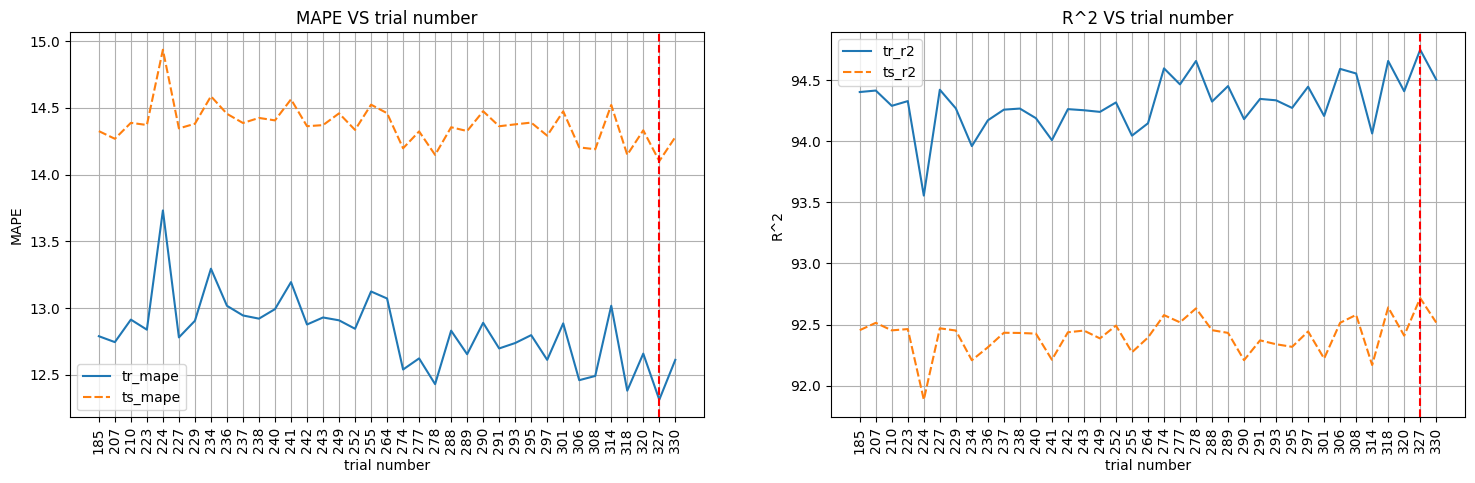

In [ ]:
# Создадим датафрейм из объекта исследования и отфильтруем минимальные
# значения метрики
data_xgb = study_xgb_of.trials_dataframe()
best_params = data_xgb[data_xgb['value'] <= 16.95]

# Определим списки для сбора значений метрик
num = []
tr_mape = []
ts_mape = []
tr_r2 = []
ts_r2 = []

# В цикле будем задавать значений гиперпараметров по отфильтрованным
# результатам исследования
for i in range(best_params.shape[0]):
    params = {'lambda': best_params.iloc[i]['params_lambda'],
              'alpha': best_params.iloc[i]['params_alpha'],
              'colsample_bytree': best_params.
              iloc[i]['params_colsample_bytree'],
              'subsample': best_params.iloc[i]['params_subsample'],
              'learning_rate': best_params.iloc[i]['params_learning_rate'],
              'n_estimators': best_params.iloc[i]['params_n_estimators'],
              'max_depth': best_params.iloc[i]['params_max_depth'],
              'min_child_weight': best_params.
              iloc[i]['params_min_child_weight'],
              'random_state': 42,
              'tree_method': 'hist'
              }

    # Создаем модель и передаем в нее гиперпараметры
    model = XGBRegressor(**params)

    # Обучаем модель
    model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

    # Делаем предсказания на обеих выборках для контроля переобуения модели
    tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
    ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

    # Рассчитываем метрики и заносим их в списки
    num.append(best_params.iloc[i]['number'])
    tr_mape.append(metrics.mean_absolute_percentage_error(y_true=y_train,
                                                          y_pred=tr_pred
                                                          )*100)
    ts_mape.append(metrics.mean_absolute_percentage_error(y_true=y_test,
                                                          y_pred=ts_pred
                                                          )*100)
    tr_r2.append(metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    ts_r2.append(metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)

# Формируем  датафрейм из полученных списокв
metric = pd.DataFrame({'number': num,
                       'tr_mape': tr_mape,
                       'ts_mape': ts_mape,
                       'tr_r2': tr_r2,
                       'ts_r2': ts_r2
                       }
                      )

# Строим графики. Определяем размер фигуры и количество полей
fig, ax = plt.subplots(ncols=2, figsize=(18, 5))

# На первом поле выводим графики для метрики МАРЕ
sns.lineplot(metric[['tr_mape', 'ts_mape']], ax=ax[0])

# На втором поле выводим графики для метрики R^2
sns.lineplot(metric[['tr_r2', 'ts_r2']], ax=ax[1])

# Строим вертикальную линию для отображения лучшего результатат по метрике МАРЕ
ax[0].axvline(x=metric[metric['ts_mape'] == metric['ts_mape'].min()].index[0],
              c='red',
              linestyle='--'
              )

# Строим вертикальную линию для отображения лучшего результатат по метрике R^2
ax[1].axvline(x=metric[metric['ts_r2'] == metric['ts_r2'].max()].index[0],
              c='red',
              linestyle='--'
              )

# Определяем метки и имена осей, графиков и включаем отображение сетки
ax[0].set_xticks(range(len(metric)), labels=metric['number'], rotation=90)
ax[1].set_xticks(range(len(metric)), labels=metric['number'], rotation=90)
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('R^2')
ax[0].set_xlabel('trial number')
ax[1].set_xlabel('trial number')
ax[0].set_title('MAPE VS trial number')
ax[1].set_title('R^2 VS trial number')
ax[0].grid()
ax[1].grid()


In [ ]:
# Задаем лучшие значения гиперпараметров
params = {'lambda': best_params.loc[327, 'params_lambda'],
          'alpha': best_params.loc[327, 'params_alpha'],
          'colsample_bytree': best_params.loc[327, 'params_colsample_bytree'],
          'subsample': best_params.loc[327, 'params_subsample'],
          'learning_rate': best_params.loc[327, 'params_learning_rate'],
          'n_estimators': best_params.loc[327, 'params_n_estimators'],
          'max_depth': best_params.loc[327, 'params_max_depth'],
          'min_child_weight': best_params.loc[327, 'params_min_child_weight'],
          'random_state': 42,
          'tree_method': 'hist'
          }

# Создаем модель и передаем в нее гиперпараметры
model = XGBRegressor(**params)

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 12.312295511895094
TS MAPE 14.100687457918054
TR R^2 94.7507917881012
TS R^2 92.71652102470398
--------------------------------------------------


Проверка ближайших значений гиперпараметров позволила еще немного улучшить метрики. Метрика МАРЕ на тестовой выборке уменьшилась на 0.063 процента, метрика R квадрат увеличалась на 2.        
Целевой параметр имеет очень большой разброс, стоит попробовать при подборе гиперпараметров функцию сильнее штрафующую за большие ошибки. Попробуем осуществить подбор параметров с MSE в качестве функции ошибки.

In [42]:
# Создаем объект исследования
# study_xgb_mse = optuna.create_study(study_name='XGBoost',
#                                 direction='minimize')

# Загружаем объект исследований
study_xgb_mse = joblib.load('./data/optuna_exp/experiments_xgb_mse.pkl')

In [ ]:
# Определяем функцию для оптимизации
def opt_xgb_mse(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    param = {'tree_method': 'hist',
             'lambda': trial.suggest_float('lambda',
                                           low=1e-3,
                                           high=10.0,
                                           step=1e-3
                                           ),
             'alpha': trial.suggest_float('alpha',
                                          low=1e-3,
                                          high=10.0,
                                          step=1e-3
                                          ),
             'colsample_bytree': trial.suggest_float('colsample_bytree',
                                                     low=0.3,
                                                     high=1.0,
                                                     step=0.1
                                                     ),
             'subsample': trial.suggest_float('subsample',
                                              low=0.4,
                                              high=1.0,
                                              step=0.1
                                              ),
             'learning_rate': trial.suggest_float('learning_rate',
                                                  low=0.008,
                                                  high=1.0,
                                                  step=0.002
                                                  ),
             'n_estimators': trial.suggest_int('n_estimators',
                                               low=100,
                                               high=10000,
                                               step=5
                                               ),
             'max_depth': trial.suggest_int('max_depth',
                                            low=2,
                                            high=20,
                                            step=1
                                            ),
             'random_state': trial.suggest_categorical('random_state',
                                                       [seed]
                                                       ),
             'min_child_weight': trial.suggest_int('min_child_weight',
                                                   low=1,
                                                   high=300,
                                                   step=1
                                                   ),
             }

    # Создаем модель
    model = XGBRegressor(**param)

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МSЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score_mse,
                                            return_train_score=True
                                            )

    # Вычисляем среднее значение метрики на тестовых фолдах
    score = result['test_score'].mean()

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_xgb_mse.optimize(opt_xgb_mse, n_trials=1)
    joblib.dump(study_xgb_mse, './data/optuna_exp/experiments_xgb_mse.pkl')

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params XGB_mse: ', study_xgb_mse.best_params)
print('MSE: ', study_xgb_mse.best_value)


Best params XGB_mse:  {'lambda': 5.674, 'alpha': 6.665, 'colsample_bytree': 0.8, 'subsample': 0.7000000000000001, 'learning_rate': 0.10800000000000001, 'n_estimators': 4265, 'max_depth': 9, 'random_state': 42, 'min_child_weight': 68}
MSE:  7440340041021.189


In [ ]:
# Задаем лучшие значения гиперпараметров
params = {'lambda': 5.674,
          'alpha': 6.665,
          'colsample_bytree': 0.8,
          'subsample': 0.7,
          'learning_rate': 0.108,
          'n_estimators': 4265,
          'max_depth': 9,
          'random_state': 42,
          'min_child_weight': 68,
          'tree_method': 'hist'
          }

# Создаем модель и передаем в нее гиперпараметры
model = XGBRegressor(**params)

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 8.234750182733078
TS MAPE 13.748304951755868
TR R^2 97.48668670654297
TS R^2 93.37921142578125
--------------------------------------------------


Значение метрик улучшилось, но разница между результатами на тренировочной и тестовой выборке также увеличилась до 5.5 процентов по метрик МАРЕ. Попробуем избавится от переобучения

In [45]:
# Создаем объект исследования
# study_xgb_mse_of = optuna.create_study(study_name='XGBoost',
#                                 direction='minimize')

# Загружаем объект исследований
study_xgb_mse_of = joblib.load('./data/optuna_exp/experiments_xgb_mse_of.pkl')

In [ ]:
# Определяем функцию для оптимизации
def opt_xgb_mse_of(trial):
    """Функция принимает объект исследования, определяет пространство поиска
    гиперпараметров, модель и вычисляет для текущей комбинации гиперпараметров
    функцию ошибки

    Args:
        trial (optuna.trial): экземпляр Trial, объект исследования,
        представляющий собой процесс оценки целевой функции

    Returns:
        float: значение функции ошибки
    """
    # Задаем пространство поиска гиперпараметров
    param = {'tree_method': 'hist',
             'lambda': trial.suggest_float('lambda',
                                           low=1e-3,
                                           high=10.0,
                                           step=1e-3
                                           ),
             'alpha': trial.suggest_float('alpha',
                                          low=1e-3,
                                          high=10.0,
                                          step=1e-3
                                          ),
             'colsample_bytree': trial.suggest_float('colsample_bytree',
                                                     low=0.3,
                                                     high=1.0,
                                                     step=0.1
                                                     ),
             'subsample': trial.suggest_float('subsample',
                                              low=0.4,
                                              high=1.0,
                                              step=0.1
                                              ),
             'learning_rate': trial.suggest_float('learning_rate',
                                                  low=0.008,
                                                  high=1.0,
                                                  step=0.002
                                                  ),
             'n_estimators': trial.suggest_int('n_estimators',
                                               low=100,
                                               high=10000,
                                               step=5
                                               ),
             'max_depth': trial.suggest_int('max_depth',
                                            low=2,
                                            high=20,
                                            step=1
                                            ),
             'random_state': trial.suggest_categorical('random_state',
                                                       [seed]
                                                       ),
             'min_child_weight': trial.suggest_int('min_child_weight',
                                                   low=1,
                                                   high=300,
                                                   step=1
                                                   ),
             }

    # Создаем модель
    model = XGBRegressor(**param)

    # Метрику будем определять с применением кросс-валидации и функции для
    # подсчета МSЕ из модуля myfunc
    result = model_selection.cross_validate(estimator=model,
                                            X=x_tr_r[best_dt_importance],
                                            y=np.log(y_train+1),
                                            cv=5,
                                            scoring=get_score_mse,
                                            return_train_score=True
                                            )

    # Чтобы избежать переобучения попробуем к метрике добавлять модуль разницы
    # между средним значением на тестовой и тренировочной выборке
    score = result['test_score'].mean() + abs(result['train_score'].mean() -
                                              result['test_score'].mean())

    # Возвращаем полученное значение метрики
    return score


# На случай сбоев оптимизацию будем проводить в цикле
# записывая на каждой итерации объект исследования в файл
for i in range(0):

    # Проводим подбор гиперпараметров и записываем обновленный объект
    # исследования в файл
    study_xgb_mse_of.optimize(opt_xgb_mse_of, n_trials=1)
    joblib.dump(study_xgb_mse_of,
                './data/optuna_exp/experiments_xgb_mse_of.pkl'
                )

# Выводим гиперпараметры лучшей модели и значение метрики МАРЕ
print('Best params XGB_mse_of: ', study_xgb_mse_of.best_params)
print('MSE: ', study_xgb_mse_of.best_value)


Best params XGB_mse_of:  {'lambda': 9.475, 'alpha': 3.054, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.038, 'n_estimators': 9565, 'max_depth': 4, 'random_state': 42, 'min_child_weight': 209}
MSE:  10479384854790.59


In [ ]:
# Задаем лучшие значения гиперпараметров
params = {'lambda': 9.475,
          'alpha': 3.054,
          'colsample_bytree': 0.5,
          'subsample': 1.0,
          'learning_rate': 0.038,
          'n_estimators': 9565,
          'max_depth': 4,
          'random_state': 42,
          'min_child_weight': 209,
          'tree_method': 'hist'
          }

# Создаем модель и передаем в нее гиперпараметры
model = XGBRegressor(**params)

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 12.365735741750752
TS MAPE 14.147544294219216
TR R^2 94.7920560836792
TS R^2 92.78239607810974
--------------------------------------------------


Результат получился сопоставим с результатом полученным при подборе гиперпараметров с помощью функции ошибки MAPE. Проверим на целевой метрике несколько наборов гиперпараметров показавших лучший результат. Лучшее значение метрики при подборе гиперпараметров было 1.04e+13. Зададим порог значения метрики 1.069977e+13 и проверим результаты работы модели для наборов гиперпараметров дающих такие значения.

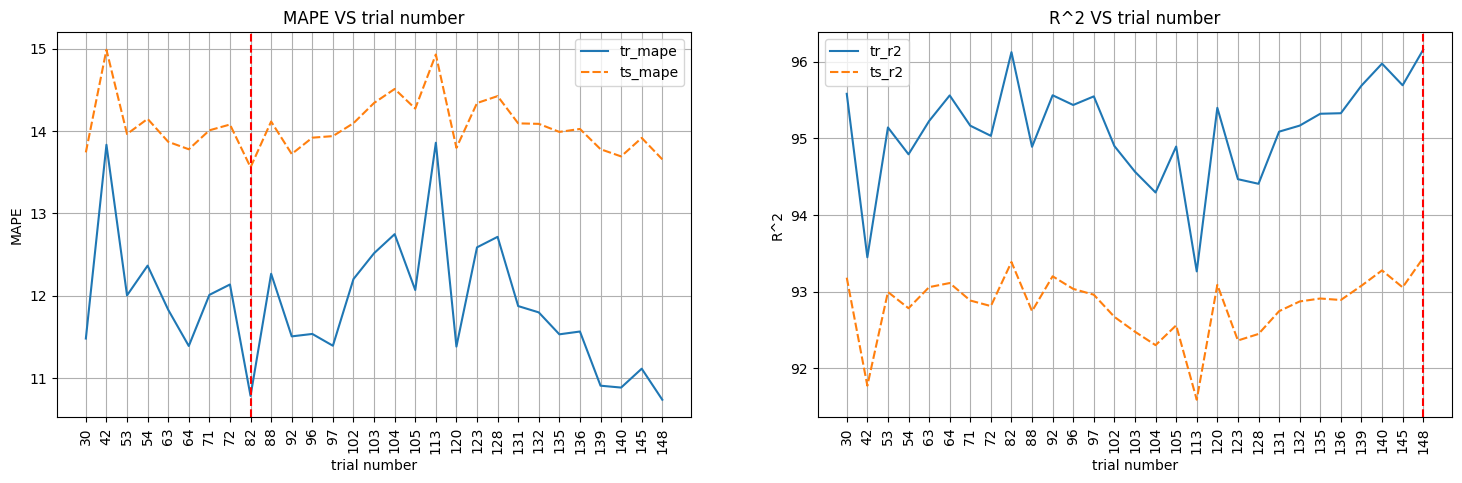

In [ ]:
# Создадим датафрейм из объекта исследования и отфильтруем минимальные
# значения метрики
data_xgb = study_xgb_mse_of.trials_dataframe()
best_params = data_xgb[data_xgb['value'] <= 1.069977e+13]

# Определим списки для сбора значений метрик
num = []
tr_mape = []
ts_mape = []
tr_r2 = []
ts_r2 = []

# В цикле будем задавать значений гиперпараметров по отфильтрованным
# результатам исследования
for i in range(best_params.shape[0]):
    params = {'lambda': best_params.iloc[i]['params_lambda'],
              'alpha': best_params.iloc[i]['params_alpha'],
              'colsample_bytree': best_params.
              iloc[i]['params_colsample_bytree'],
              'subsample': best_params.iloc[i]['params_subsample'],
              'learning_rate': best_params.iloc[i]['params_learning_rate'],
              'n_estimators': best_params.iloc[i]['params_n_estimators'],
              'max_depth': best_params.iloc[i]['params_max_depth'],
              'min_child_weight': best_params.
              iloc[i]['params_min_child_weight'],
              'random_state': 42,
              'tree_method': 'hist'
              }

    # Создаем модель и передаем в нее гиперпараметры
    model = XGBRegressor(**params)

    # Обучаем модель
    model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

    # Делаем предсказания на обеих выборках для контроля переобуения модели
    tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
    ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

    # Рассчитываем метрики и заносим их в списки
    num.append(best_params.iloc[i]['number'])
    tr_mape.append(metrics.mean_absolute_percentage_error(y_true=y_train,
                                                          y_pred=tr_pred
                                                          )*100)
    ts_mape.append(metrics.mean_absolute_percentage_error(y_true=y_test,
                                                          y_pred=ts_pred
                                                          )*100)
    tr_r2.append(metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
    ts_r2.append(metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)

# Формируем  датафрейм из полученных списокв
metric = pd.DataFrame({'number': num,
                       'tr_mape': tr_mape,
                       'ts_mape': ts_mape,
                       'tr_r2': tr_r2,
                       'ts_r2': ts_r2
                       }
                      )

# Строим графики. Определяем размер фигуры и количество полей
fig, ax = plt.subplots(ncols=2, figsize=(18, 5))

# На первом поле выводим графики для метрики МАРЕ
sns.lineplot(metric[['tr_mape', 'ts_mape']], ax=ax[0])

# На втором поле выводим графики для метрики R^2
sns.lineplot(metric[['tr_r2', 'ts_r2']], ax=ax[1])

# Строим вертикальную линию для отображения лучшего результатат по метрике МАРЕ
ax[0].axvline(x=metric[metric['ts_mape'] == metric['ts_mape'].min()].index[0],
              c='red',
              linestyle='--'
              )

# Строим вертикальную линию для отображения лучшего результатат по метрике R^2
ax[1].axvline(x=metric[metric['ts_r2'] == metric['ts_r2'].max()].index[0],
              c='red',
              linestyle='--'
              )

# Определяем метки и имена осей, графиков и включаем отображение сетки
ax[0].set_xticks(range(len(metric)), labels=metric['number'], rotation=90)
ax[1].set_xticks(range(len(metric)), labels=metric['number'], rotation=90)
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('R^2')
ax[0].set_xlabel('trial number')
ax[1].set_xlabel('trial number')
ax[0].set_title('MAPE VS trial number')
ax[1].set_title('R^2 VS trial number')
ax[0].grid()
ax[1].grid()


In [ ]:
# Задаем лучшие по метрике МАРЕ значения гиперпараметров
params = {'lambda': best_params.loc[82, 'params_lambda'],
          'alpha': best_params.loc[82, 'params_alpha'],
          'colsample_bytree': best_params.loc[82, 'params_colsample_bytree'],
          'subsample': best_params.loc[82, 'params_subsample'],
          'learning_rate': best_params.loc[82, 'params_learning_rate'],
          'n_estimators': best_params.loc[82, 'params_n_estimators'],
          'max_depth': best_params.loc[82, 'params_max_depth'],
          'min_child_weight': best_params.loc[82, 'params_min_child_weight'],
          'random_state': 42,
          'tree_method': 'hist'
          }

# Создаем модель и передаем в нее гиперпараметры
model = XGBRegressor(**params)

# Обучаем модель
model.fit(x_tr_r[best_dt_importance], np.log(y_train+1))

# Делаем предсказания на обеих выборках для контроля переобуения модели
tr_pred = np.exp(model.predict(x_tr_r[best_dt_importance]))-1
ts_pred = np.exp(model.predict(x_ts_r[best_dt_importance]))-1

# Рассчитываем и выводим метрики
print('TR MAPE', metrics.mean_absolute_percentage_error(y_true=y_train,
                                                        y_pred=tr_pred
                                                        )*100)
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=y_test,
                                                        y_pred=ts_pred
                                                        )*100)
print('TR R^2', metrics.r2_score(y_true=y_train, y_pred=tr_pred)*100)
print('TS R^2', metrics.r2_score(y_true=y_test, y_pred=ts_pred)*100)
print('-'*50)


TR MAPE 10.78418902627187
TS MAPE 13.559422392062654
TR R^2 96.12541198730469
TS R^2 93.38600039482117
--------------------------------------------------


Проверка ближайших значений гиперпараметров позволила улучшить метрики. Метрика МАРЕ на тестовой выборке составила 13.56 процента, метрика R квадрат - 93.39. Разница в значении метрики МАРЕ для тренировочной и тестовой выборки сотавила 2.78 процента. Остановимся на этом результате и подготовим пайплайн с предобработкой данных и самой моделью

## Подготовка пайплайна

Итак в процессе работы мы уже сохранили необходимые для трансформеров файлы и саму модель. Дополнительно нам потребуется словарь, содержащий наименование городов и их координаты.

In [ ]:
# Получим список городов России с населением более 100 тысяч его с сайта
# википедии.
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA' + \
      '_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1' + \
      '%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD' + \
      '%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%' + \
      '8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9'

# Считываем страницу
tab = pd.read_html(url)

# Формируем таблицу
sity_tab = tab[0].loc[:, 'Город']

# Выделим список городов и преобразуем в список
sitys = sity_tab['Город'].to_list()

# Наименование некоторых городов содержат ссылки заключенные в квадратные
# скобки. Избавимся от них. Создадим список для сбора наименований городов
sity_ls = []

# В цикле перебираем наименования городов
for sity in sitys:

    # Если оно включает открывающуюся квадратную скобку
    if '[' in sity:

        # Заносим в список срез строки до индекса элемента ее содержащего
        sity_ls.append(sity[:sity.index('[')])

    # Иначе просто включаем наименование города в список
    else:
        sity_ls.append(sity)


In [ ]:
# Получим координаты городов.
# Зададим пустой словарь для сбора координат городов
coordinate = {}

# Используем геокодер Nominatim.
# Для работы нужно указать название приложения.
geolocator = Nominatim(user_agent="Tester")

# В цикле перебираем наименования городов
for elem in sity_ls:

    # Передаем наименование города в метод geocode экземпляра геолокатора.
    # На выходе получаем полный адрес и кортеж с координатами. Записываем
    # в переменную координаты объекта.
    loc = geolocator.geocode(elem)[-1]

    # Вносим координаты в словарь для текущего наименования города
    coordinate[elem] = loc

# Сериализуем и запишем словарь с координатами в файл
with open('./file_pkl/coordinate.pkl', 'wb') as file:
    pickle.dump(coordinate, file)


Трансформеры данных будем ис пользовать свои из модуля myfunc:            
   + sity_to_loc_transform - создает два признака с долготой и широтой города;
   + encoder_transform - проводит однократное и бинарное кодирование, а также убирает лишние признаки;
   + robust_scaler - удаляет признаки с высокой корреляцией, восстанавливает порядок признаков и применяет сохраненный robust трансформер, который мы сохранили ранее;
   + best_features - возвращает срез из наиболее важных признаков.           
   
После трансформации данные передаются в модель показавшую наилучший результат. 

In [ ]:
# Создаем пайплайн
pipe = Pipeline([('sity_to_loc', sity_to_loc_transform()),
                 ('encoder_transform', encoder_transform()),
                 ('robust_scaler', robust_scaler()),
                 ('best_features', best_features()),
                 ('model', model)
                 ]
                )

# Сериализуем и записываем пайплайн в файл
with open('./file_pkl/pipe.pkl', 'wb') as out:
    pickle.dump(pipe, out)


In [ ]:
# Загрузим наш пайплайн для проверки
with open('./file_pkl/pipe.pkl', 'rb') as pkl_file:
    loaded_pipe = pickle.load(pkl_file)


In [ ]:
# Подготовим данные для проверки
df = pd.read_csv('./data/auto_data.csv')

# Удалим лишние признаки, их создаст пайплайн
df = df.drop(['lat', 'long'], axis=1)

# Обработаем выбросы в данных как было сделано ранее
features = ['price', 'eng_hpower', 'tax', 'mileage', 'year']

# В цикле перебираем список признаков features
for feature in features:

    # Используем функцию outliers_irq из модуля myfunc и переопределяем
    # наш датасет
    _, df = outliers_irq(df, feature)

# Сбрасываем значения индексов
df = df.reset_index(drop=True)

# Загружаем индексы тестовой выборки
with open('./file_pkl/test_index.pkl', 'rb') as pkl_file:
    test_index = pickle.load(pkl_file)

# Оставляем в датасете только тестовые данные
df = df.loc[test_index, :]

# Сохраним очищенный датасет он понадобится для тестов при запсуке модели
# в продакшен
df.to_csv('./data/clear_auto_data.csv')


In [ ]:
# Сформируем матрицу признаков для тестовых данных
X = df.drop('price', axis=1)

# И запустим загруженный пайплайн и делаем предсказания для проверки
res = loaded_pipe.predict(X)

# Возвращаем обычный масштаб
ts_pred = np.exp(res)-1

# Рассчитываем и выводим метрики
print('TS MAPE', metrics.mean_absolute_percentage_error(y_true=df['price'],
                                                        y_pred=ts_pred
                                                        )*100
      )
print('TS R^2', metrics.r2_score(y_true=df['price'], y_pred=ts_pred)*100)


TS MAPE 13.559422392062654
TS R^2 93.38600039482117


## Выводы
Подготовлен пайплайн преобразующий данные из стандартной анкеты подачи объявления с сайта auto.ru к виду подходящему для передачи в модель градиентного бустинга с регуляризацией из библиотеки XGBoost. Данная модель показала лучший результат. Метрика МАРЕ на тестовой выборке составила 13.56 процента, метрика R квадрат - 93.39. Проверка пайплайна выполнена, можно приступать к внедрения в production.

